In [206]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from imblearn.under_sampling import RandomUnderSampler
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Descargar recursos de NLTK (si es la primera vez)
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\04aim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\04aim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\04aim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\04aim\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [207]:
# Cargar los datos
data = pd.read_csv("reviews_cascos_gaming.csv",sep=';', encoding="utf-8")

In [208]:
lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()
snowball = SnowballStemmer('spanish')

def quitar_tildes(texto):
    texto = unicodedata.normalize("NFD", texto)  # Descomponer caracteres con tilde
    texto = "".join(c for c in texto if unicodedata.category(c) != "Mn")  # Eliminar solo las tildes
    return unicodedata.normalize("NFC", texto)  # Recomponer texto normalizado
    
def limpiar_texto(texto):
    texto = re.sub(r"[^a-zA-Z\s]", " ", texto)
    texto = quitar_tildes(texto)
    texto = texto.lower()
    palabras = word_tokenize(texto)
    palabras = [lemmatizer.lemmatize(palabra) for palabra in palabras] 
    # Stemming
    # palabras = [porter.stem(palabra) for palabra in word_tokenize(texto)]
    # palabras = [snowball.stem(palabra) for palabra in word_tokenize(texto)]
    # Eliminar stopwords
    palabras = [palabra for palabra in palabras if palabra not in stopwords.words("spanish")]
    return " ".join(palabras)

def sin_limpiar_texto(texto):
    return texto

# data["review"] = data["review"].apply(limpiar_texto)

In [209]:
# import re
# import unicodedata
# from nltk.tokenize import word_tokenize

# # Lista de palabras ambiguas que deben ser consideradas en bigramas
# palabras_ambiguas = {"calidad", "funciona", "buena", "malo", "producto", "sonido", "precio", "recomiendo"}

# def procesar_texto_con_bigramas(texto):
#     # Quitar caracteres especiales y convertir a minúsculas
#     texto = re.sub(r"[^a-zA-Z\s]", " ", texto)
#     texto = quitar_tildes(texto).lower()
    
#     # Tokenizar palabras
#     palabras = word_tokenize(texto)
    
#     # Construir bigramas manualmente
#     bigramas = ["_".join(pair) for pair in zip(palabras, palabras[1:])]
    
#     # Filtrar bigramas que contienen al menos una palabra ambigua
#     palabras_finales = {big for big in bigramas if any(word in big for word in palabras_ambiguas)}
    
#     # Si hay menos de 3 bigramas, agregar palabras ambiguas individuales para asegurar contenido
#     if len(palabras_finales) < 3:
#         palabras_finales.update(set(palabra for palabra in palabras if palabra in palabras_ambiguas))
    
#     return " ".join(palabras_finales)

# # Aplicar preprocesamiento
# data["review"] = data["review"].apply(procesar_texto_con_bigramas)


In [210]:
data = pd.read_csv("reviews_cascos_gaming.csv",sep=';', encoding="utf-8")

top = 15

# Cargar datos
reseñas = data['review'].astype(str).fillna("").apply(limpiar_texto)

# Vectorización con BoW
vectorizer = CountVectorizer()
X = reseñas
y = data['stars']

# Dividir en entrenamiento, validación y prueba
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.5, random_state=12)

X_train = vectorizer.fit_transform(X_train)

# Entrenar el modelo de Regresión Logística
modelo_lr = LogisticRegression(random_state=12, class_weight="balanced", C=1, max_iter=1000)
modelo_lr.fit(X_train, Y_train)

# Obtener coeficientes de importancia
coeficientes = np.abs(modelo_lr.coef_).mean(axis=0)  # Promedio de coeficientes en todas las clases

# Obtener vocabulario
vocabulario = np.array(vectorizer.get_feature_names_out())

# Seleccionar las Top N palabras con más peso en el modelo
top_indices = np.argsort(coeficientes)[-top:]  # Índices de las palabras más influyentes
palabras_clave = set(vocabulario[top_indices])  # Convertir a conjunto para búsqueda rápida

print(f"Palabras clave seleccionadas: {palabras_clave}")


def filtrar_reseña(reseña, palabras_clave):
    palabras = reseña.split()  # Separar en palabras
    palabras_filtradas = [palabra for palabra in palabras if palabra in palabras_clave]
    return " ".join(palabras_filtradas) if palabras_filtradas else reseña  # Si no hay palabras clave, conservar el original

# Aplicar la función a las reseñas de validación
# reseñas_val = data.loc[X_val.indices, 'review'].astype(str).fillna("")
X_val = X_val.apply(lambda x: filtrar_reseña(x, palabras_clave))

# data.loc[X_val.indices, 'review_filtrada'] = reseñas_filtradas


Palabras clave seleccionadas: {'funciona', 'van', 'devolv', 'encantado', 'gustaron', 'perfectamente', 'mal', 'momento', 'bien', 'modos', 'buen', 'genial', 'funcionar', 'auricular', 'calidad'}


In [211]:
X_val.to_csv("review_preprocesada.csv", index=False, sep=';')
print(X_val)
print(len(X_val))

324                              calidad
143                             funciona
725                      calidad calidad
520                              calidad
512    bien funcionar funcionar funciona
                     ...                
729             funciona calidad calidad
407                            buen bien
495                            bien buen
378                              momento
677                          buen genial
Name: review, Length: 316, dtype: object
316


In [212]:
# reseñas = reseñas_filtradas.astype(str).fillna("")
# reseñas = data['review'].astype(str).fillna("")

# Vectorización BoW
def bow(reseñas):
    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(reseñas)

# Vectorizacion TIF
def tif(reseñas):
    vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=5000)
    return vectorizer.fit_transform(reseñas)

# X = bow(reseñas)
# X = tif(reseñas)
# y = data['stars']

In [213]:
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [214]:

# # Vectorización con Bag of Words
# vectorizer = CountVectorizer(max_features=5000)
# X = vectorizer.fit_transform(reseñas)

# # Separar datos en entrenamiento y prueba
# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# # Entrenar modelo Naive Bayes
# modelo_nb = MultinomialNB(alpha=2)
# modelo_nb.fit(X_train, Y_train)

# # Predecir y evaluar
# y_test_pred = modelo_nb.predict(X_test)
# acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)
# print(f"Accuracy de Naive Bayes: {acc}%")

# # Obtener palabras más relevantes
# vocabulario = vectorizer.get_feature_names_out()
# probabilidades = np.exp(modelo_nb.feature_log_prob_)

# # # Crear histogramas por cada estrella
# # for i, estrellas in enumerate(modelo_nb.classes_):
# #     # Seleccionar las 15 palabras más relevantes
# #     top_indices = np.argsort(probabilidades[i])[-15:]  # Tomamos las 15 más altas
# #     palabras_top = [vocabulario[idx] for idx in top_indices]
# #     probabilidades_top = [probabilidades[i, idx] for idx in top_indices]

# #     # Graficar histograma
# #     plt.figure(figsize=(10, 5))
# #     plt.barh(palabras_top, probabilidades_top, color='skyblue')
# #     plt.xlabel("Probabilidad")
# #     plt.ylabel("Palabras")
# #     plt.title(f" Palabras más influyentes para {estrellas} estrellas")
# #     plt.gca().invert_yaxis()  # Invertir eje Y para que la palabra más relevante esté arriba
# #     plt.show()


# # Crear figura con 2 filas y 2 columnas
# fig, axes = plt.subplots(3, 2, figsize=(12, 10))  
# axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

# for i, estrellas in enumerate(modelo_nb.classes_):
#     # Seleccionar las 15 palabras más relevantes
#     top_indices = np.argsort(probabilidades[i])[-15:]  # Tomamos las 15 más altas
#     palabras_top = [vocabulario[idx] for idx in top_indices]
#     probabilidades_top = [probabilidades[i, idx] for idx in top_indices]

#     # Graficar en la subfigura correspondiente
#     ax = axes[i]
#     ax.barh(palabras_top, probabilidades_top, color='skyblue')
#     ax.set_xlabel("Probabilidad")
#     ax.set_ylabel("Palabras")
#     ax.set_title(f"Palabras más influyentes para {estrellas}⭐")
#     ax.invert_yaxis()  # Invertir eje Y para que la palabra más relevante esté arriba

# # Ajustar el diseño para evitar superposiciones
# plt.tight_layout()
# plt.show()


In [215]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Simulación de etiquetas reales y predichas 
y_true = np.array([5, 4, 3, 5, 2, 1, 4, 3, 5, 2])
y_pred = np.array([5, 3, 3, 4, 2, 1, 4, 2, 5, 3])

# Crear matriz de confusión
def matriz_confusion(y,y_pred):   
    cm = confusion_matrix(y, y_pred, labels=[1, 2, 3, 4, 5])

    # Visualizar la matriz de confusión
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
    plt.xlabel("Clase Predicha")
    plt.ylabel("Clase Real")
    plt.title("Matriz de Confusión")
    plt.show()
    return
# matriz_confusion(y_true,y_pred)

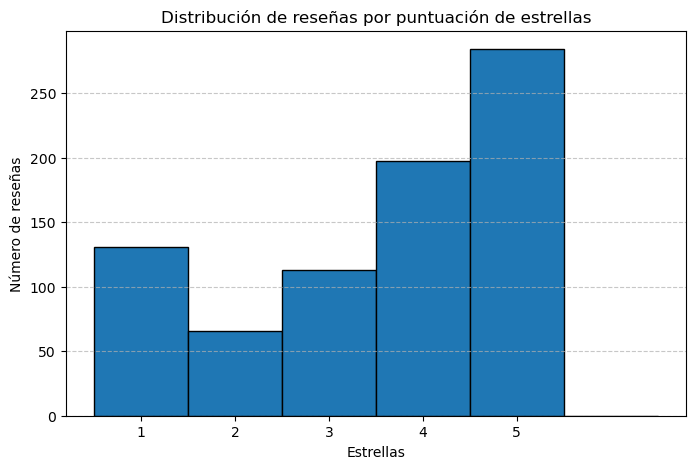

In [216]:
def distribucion_estrellas(y):
    # Crear histograma de la distribución de estrellas
    plt.figure(figsize=(8, 5))
    plt.hist(y, bins=range(1, 8), edgecolor='black', align='left')
    plt.xticks(range(1, 6))  # Ajustar ticks a las puntuaciones de 1 a 5
    plt.xlabel("Estrellas")
    plt.ylabel("Número de reseñas")
    plt.title("Distribución de reseñas por puntuación de estrellas")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    return

distribucion_estrellas(y)

In [217]:
def distancia_predicciones(y, y_pred):
    y = np.array(y)  
    y_pred = np.array(y_pred)

    # Crear índices con espaciado uniforme más grande
    x_indices = np.linspace(0, len(y) * 2.5, len(y))  # Factor 2.5 para mayor separación

    plt.figure(figsize=(12, 6))

    # Graficar la clase real vs la predicha con separación uniforme
    plt.scatter(x_indices, y, color="blue", label="Clase Real", marker="o", s=100)
    plt.scatter(x_indices, y_pred, color="red", label="Clase Predicha", marker="x", s=100)

    # Conectar con líneas para ver las diferencias
    for i in range(len(y)):
        plt.plot([x_indices[i], x_indices[i]], [y[i], y_pred[i]], color="gray", linestyle="--", alpha=0.6)

    plt.xlabel("Índice de Muestra (Separación Uniforme)")
    plt.ylabel("Clase")
    plt.title("Comparación entre Clases Reales y Predichas")
    plt.xticks([])  # Ocultar etiquetas en el eje X para evitar saturación visual
    plt.legend()
    plt.show()



# distancia_predicciones(y_true,y_pred)

In [218]:
import numpy as np
import matplotlib.pyplot as plt

def distancia_predicciones_barras(y, y_pred):
    y = np.array(y)  
    y_pred = np.array(y_pred)
    
    # Calcular la diferencia entre la clase real y la predicha
    diferencia = y - y_pred  

    # Crear etiquetas para cada muestra
    indices = np.arange(len(y))

    plt.figure(figsize=(14, 7))

    # Barras para clase real
    plt.bar(indices, y, color='blue', alpha=0.6, label='Clase Real')

    # Barras para diferencia (positiva o negativa)
    plt.bar(indices, diferencia, color='red', alpha=0.6, label='Diferencia (Real - Predicha)', bottom=y)

    # Agregar valores en las barras
    for i in range(len(y)):
        plt.text(indices[i], y[i] + diferencia[i] / 2, f"{y_pred[i]}", ha='center', va='center', 
                 color="white", fontsize=12, fontweight="bold", bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=2))

    # Expandir los límites del eje Y para evitar cortes
    plt.ylim(0, max(y) + 2)

    plt.xlabel("Índice de Muestra")
    plt.ylabel("Clase")
    plt.title("Diferencia entre Clases Reales y Predichas")
    plt.xticks(indices)  # Mostrar cada índice
    plt.yticks(range(1, max(y) + 2))  # Ajustar para las clases
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

# Ejemplo de uso con datos de prueba
y_true = np.array([5, 4, 3, 5, 2, 1, 4, 3, 5, 2])
y_pred = np.array([5, 3, 3, 4, 2, 1, 4, 2, 5, 3])

# distancia_predicciones_barras(y_true, y_pred)

# **ENTRENAMIENTO DEL MODELO**

In [219]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

#X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=12)


def entrenar_modelo(XTrain,XTest,YTrain,YTest):
    clasificadores = [
        MultinomialNB(alpha = 2),
        SVC(random_state = 12),
        LogisticRegression(random_state=12, class_weight="balanced", C = 1),
        DecisionTreeClassifier(criterion='entropy', random_state=12),  # Árbol de decisión base
        BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy', random_state=12),
                         n_estimators=15, random_state=12),  # Bagging
        AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy', random_state=12),
                           n_estimators=15, random_state=12,algorithm = 'SAMME'),  # Boosting
        RandomForestClassifier(criterion='entropy', n_estimators=15, random_state=12)  # Random Forest
    ]
    nombres = ['Naive-Bayes','SVC','LogisticRegression','DecisionTree', 'Bagging', 'Boosting', 'RandomForest']
    lista_acc = []
    for i, clasificador in enumerate(clasificadores):
        clasificador.fit(XTrain, YTrain)
        y_test_pred = clasificador.predict(XTest)
        #Evaluar modelo
        acc = round(accuracy_score(YTest, y_test_pred)*100,2)
        lista_acc.append(acc)
        print("El accuracy del clasificador ",nombres[i]," es: ",acc)
        # matriz_confusion(YTest,y_test_pred)
        mascara = YTest==5
        ytest_5 = YTest[mascara]
        y_pred_5 = y_test_pred[mascara]
        # distancia_predicciones(ytest_5,y_pred_5)
    return max(lista_acc)

acc = entrenar_modelo(X_val,X_test,Y_val,Y_test)

El accuracy del clasificador  Naive-Bayes  es:  49.06
El accuracy del clasificador  SVC  es:  47.17
El accuracy del clasificador  LogisticRegression  es:  50.94
El accuracy del clasificador  DecisionTree  es:  32.08
El accuracy del clasificador  Bagging  es:  42.77
El accuracy del clasificador  Boosting  es:  31.45
El accuracy del clasificador  RandomForest  es:  44.65


In [220]:

# Entrenar modelo de Regresión Logística
modelo_lr = LogisticRegression(random_state=12, class_weight="balanced", C=1, max_iter=1000)
modelo_lr.fit(X_train, Y_train)

# Obtener coeficientes de importancia
coeficientes = modelo_lr.coef_  # (n_clases, n_palabras)

# Obtener vocabulario
vocabulario = vectorizer.get_feature_names_out()

# Mostrar las palabras más influyentes por clase
for i, estrellas in enumerate(modelo_lr.classes_):
    top_indices = np.argsort(coeficientes[i])[-15:]  # Tomamos las 15 palabras más importantes
    palabras_top = [vocabulario[idx] for idx in top_indices]
    coef_top = [coeficientes[i, idx] for idx in top_indices]

    print(f"\n🔹 Palabras más influyentes para {estrellas} estrellas:")
    for palabra, coef in zip(palabras_top, coef_top):
        print(f"{palabra} (score: {coef:.4f})")



🔹 Palabras más influyentes para 1 estrellas:
compr (score: 0.5115)
quiere (score: 0.5293)
fono (score: 0.5400)
micr (score: 0.5402)
cable (score: 0.5622)
hace (score: 0.5846)
devuelto (score: 0.6098)
lido (score: 0.6578)
menos (score: 0.6584)
almohadillas (score: 0.6872)
especifica (score: 0.7169)
pegado (score: 0.7211)
probarlos (score: 0.7247)
dejado (score: 0.9528)
funcionar (score: 0.9676)

🔹 Palabras más influyentes para 2 estrellas:
repente (score: 0.5330)
marzo (score: 0.5666)
cuatro (score: 0.5666)
suenan (score: 0.6038)
escucha (score: 0.6566)
escuchan (score: 0.6790)
funcionaba (score: 0.6824)
microo (score: 0.8041)
devolverlo (score: 0.8041)
regular (score: 0.8503)
devolv (score: 0.8537)
auricular (score: 0.8850)
gustaron (score: 1.0119)
funciona (score: 1.0709)
mal (score: 1.6271)

🔹 Palabras más influyentes para 3 estrellas:
cuero (score: 0.4778)
mala (score: 0.5058)
alguien (score: 0.5308)
estrellas (score: 0.5491)
conector (score: 0.5571)
rato (score: 0.5672)
caros (sco

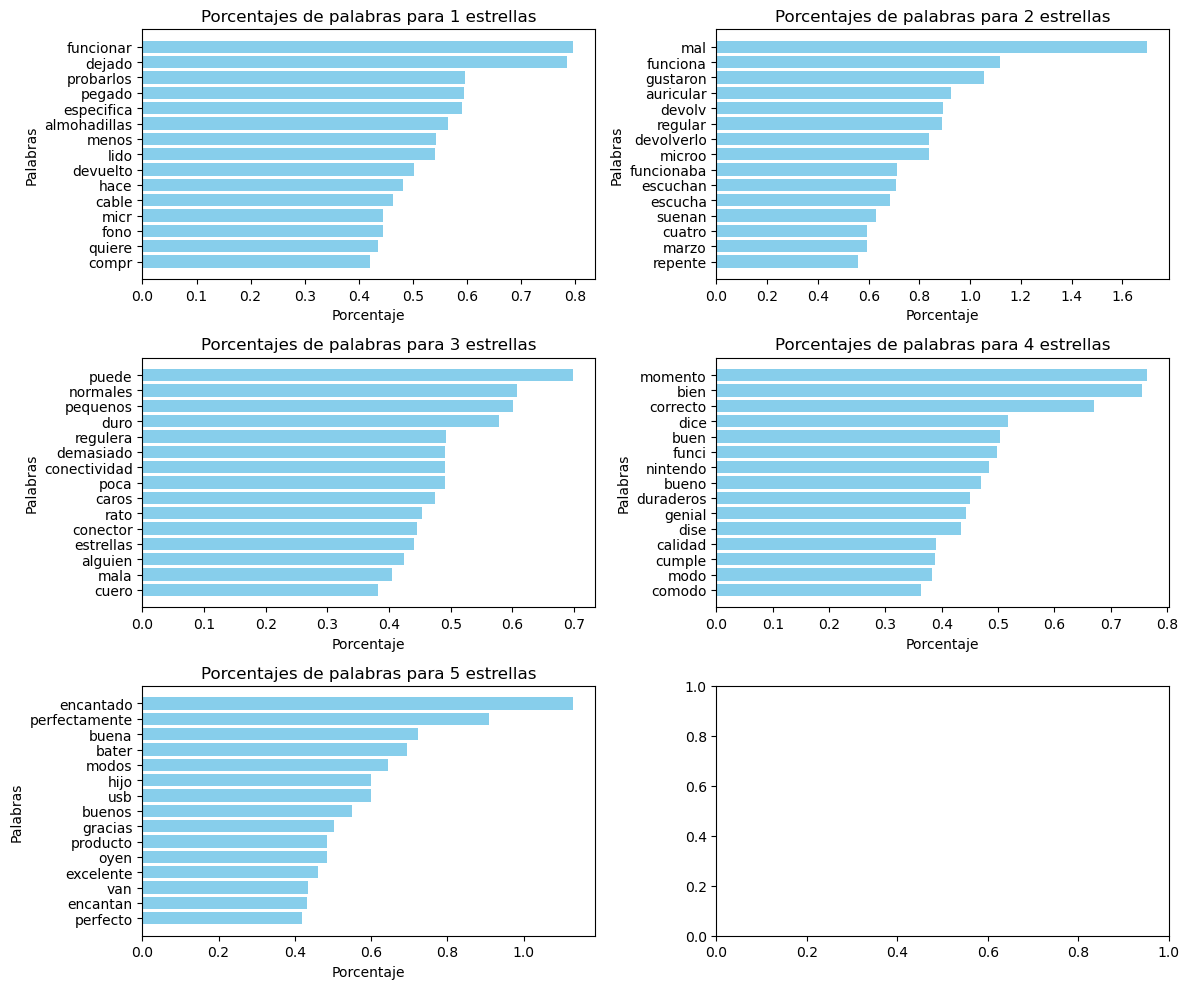

In [221]:

# Entrenar modelo de Regresión Logística
modelo_lr = LogisticRegression(random_state=12, class_weight="balanced", C=1, max_iter=1000)
modelo_lr.fit(X_train, Y_train)

# Obtener coeficientes de importancia
coeficientes = modelo_lr.coef_  # (n_clases, n_palabras)

# Obtener vocabulario
vocabulario = vectorizer.get_feature_names_out()

# Inicializar una lista para guardar los porcentajes
porcentajes_por_clase = []

# Calcular los porcentajes de cada palabra para cada clase
for i, estrellas in enumerate(modelo_lr.classes_):
    coef_class = coeficientes[i]
    total_coef = np.sum(np.abs(coef_class))  # Sumamos los coeficientes absolutos de la clase
    porcentajes = (np.abs(coef_class) / total_coef) * 100  # Convertimos en porcentaje
    
    # Guardamos los porcentajes junto con las palabras
    top_indices = np.argsort(coef_class)[-15:]  # Tomamos las 15 palabras más importantes
    palabras_top = [vocabulario[idx] for idx in top_indices]
    porcentajes_top = [porcentajes[idx] for idx in top_indices]
    
    porcentajes_por_clase.append((palabras_top, porcentajes_top))

# Crear una cuadrícula de subgráficas (3 filas, 2 columnas)
fig, axes = plt.subplots(3, 2, figsize=(12, 10))  # Tamaño reducido
axes = axes.flatten()

# Crear un gráfico por clase de estrellas
for i, (palabras_top, porcentajes_top) in enumerate(porcentajes_por_clase):
    ax = axes[i]  # Acceder a cada subgráfico
    ax.barh(palabras_top, porcentajes_top, color='skyblue')
    ax.set_title(f'Porcentajes de palabras para {modelo_lr.classes_[i]} estrellas')
    ax.set_xlabel('Porcentaje')
    ax.set_ylabel('Palabras')

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()

El accuracy del clasificador  Naive-Bayes  es:  38.99
El accuracy del clasificador  SVC  es:  38.99
El accuracy del clasificador  LogisticRegression  es:  46.54
El accuracy del clasificador  DecisionTree  es:  35.85
El accuracy del clasificador  Bagging  es:  40.88
El accuracy del clasificador  Boosting  es:  41.51
El accuracy del clasificador  RandomForest  es:  35.85
El accuracy del clasificador  Naive-Bayes  es:  38.36
El accuracy del clasificador  SVC  es:  38.99
El accuracy del clasificador  LogisticRegression  es:  49.69
El accuracy del clasificador  DecisionTree  es:  41.51
El accuracy del clasificador  Bagging  es:  42.14
El accuracy del clasificador  Boosting  es:  44.65
El accuracy del clasificador  RandomForest  es:  42.14
El accuracy del clasificador  Naive-Bayes  es:  38.36
El accuracy del clasificador  SVC  es:  39.62
El accuracy del clasificador  LogisticRegression  es:  48.43
El accuracy del clasificador  DecisionTree  es:  40.25
El accuracy del clasificador  Bagging  e

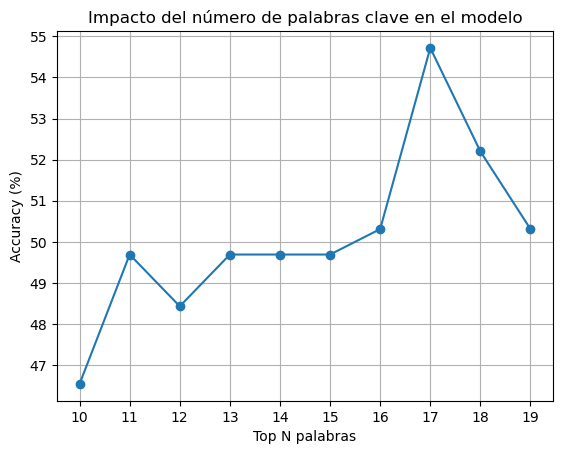

In [222]:
lista_acc = []

def limpiar_texto(texto):
    return texto.lower()

for i in range(10,20):

    data = pd.read_csv("reviews_cascos_gaming.csv",sep=';', encoding="utf-8")

    top = i

    # Cargar datos
    reseñas = data['review'].astype(str).fillna("").apply(limpiar_texto)

    # Vectorización con BoW
    vectorizer = CountVectorizer()
    X = reseñas
    y = data['stars']

    # Dividir en entrenamiento, validación y prueba
    X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, y, test_size=0.2, random_state=12)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.5, random_state=12)

    X_train = vectorizer.fit_transform(X_train)

    # Entrenar el modelo de Regresión Logística
    modelo_lr = LogisticRegression(random_state=12, class_weight="balanced", C=1, max_iter=1000)
    modelo_lr.fit(X_train, Y_train)

    # Obtener coeficientes de importancia
    coeficientes = np.abs(modelo_lr.coef_).mean(axis=0)  # Promedio de coeficientes en todas las clases

    # Obtener vocabulario
    vocabulario = np.array(vectorizer.get_feature_names_out())

    # Seleccionar las Top N palabras con más peso en el modelo
    top_indices = np.argsort(coeficientes)[-top:]  # Índices de las palabras más influyentes
    palabras_clave = set(vocabulario[top_indices])  # Convertir a conjunto para búsqueda rápida


    # Aplicar la función a las reseñas de validación
    # reseñas_val = data.loc[X_val.indices, 'review'].astype(str).fillna("")
    X_val = X_val.apply(lambda x: filtrar_reseña(x, palabras_clave))

    # data.loc[X_val.indices, 'review_filtrada'] = reseñas_filtradas


    X_val = vectorizer.transform(X_val)
    X_test = vectorizer.transform(X_test)

    lista_acc.append(entrenar_modelo(X_val,X_test,Y_val,Y_test))

# Graficar los resultados
plt.plot(range(10, 20), lista_acc, marker='o')
plt.xlabel('Top N palabras')
plt.ylabel('Accuracy (%)')
plt.title('Impacto del número de palabras clave en el modelo')
plt.xticks(range(10, 20))
plt.grid(True)
plt.show()


In [224]:
def limpiar_texto(texto):
    return texto#.lower()

data = pd.read_csv("reviews_cascos_gaming.csv",sep=';', encoding="utf-8")

# Cargar datos
reseñas = data['review'].astype(str).fillna("").apply(limpiar_texto)

# Vectorización con BoW
vectorizer = CountVectorizer()
X = reseñas
y = data['stars']

# Dividir en entrenamiento, validación y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=12)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

entrenar_modelo(X_train,X_test,Y_train,Y_test)

El accuracy del clasificador  Naive-Bayes  es:  48.43
El accuracy del clasificador  SVC  es:  50.94
El accuracy del clasificador  LogisticRegression  es:  59.75
El accuracy del clasificador  DecisionTree  es:  40.88
El accuracy del clasificador  Bagging  es:  49.06
El accuracy del clasificador  Boosting  es:  41.51
El accuracy del clasificador  RandomForest  es:  47.17


59.75